In [6]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    gen_social_network, 
    mu_sigma_to_alpha_beta, 
    exclude_new_items, 
    perfect_scores,
    interleave_new_items,
    process_measurement,
    MeanDistanceSimUsers,
    MeanInteractionDistance,
    SimilarUserInteractionSimilarity,
    InteractionTracker,
    RandomRecommender,
    ChaneyContent,
    IdealRecommender,
    load_sim_results,
    merge_results,
    graph_metrics,
    graph_relative_to_ideal,
)
from creator_sim import (
    ChaneyCreators,
    ideal_content_score_fns,
    CreatorItemHomogenization,
    sample_users_and_creators,
    init_sim_state,
    run_ideal_sim,
    run_content_sim,
    run_mf_sim,
    run_sf_sim,
    run_pop_sim,
    run_random_sim
)
import warnings
warnings.simplefilter("ignore")

In [2]:
# define constants
SEED = 1234
GENERATOR = np.random.default_rng(SEED)
NUM_USERS = 100
NUM_CREATORS = 10 
ITEMS_PER_CREATOR = 1 # each creator produces 1 item per timestep
NUM_ATTRS = 20 
NUM_SIMS = 5 # change back to 25
# parameters provided in paper 
MU_N = 0.98 
SIGMA = 1e-5
DEBUG = True # if True, figures will not be written to files

## Generate synthetic data

In [3]:
users, creators, social_networks = sample_users_and_creators(
    GENERATOR, 
    NUM_USERS, 
    NUM_CREATORS, 
    NUM_ATTRS, 
    NUM_SIMS
)

# Experiments

In [4]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
single_train_models = {}

# mostly for plotting
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content filtering",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

## Repeated training

In [5]:
sim_args = {
    "startup_iters": 10,
    "sim_iters": 90,
    "repeated_training": True,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}

In [38]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = rep_train_models["ideal"].actual_item_attributes
    rep_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


In [7]:
# for plotting purposes
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
smooth_sigma = 1.0

In [8]:
def graph_relative_to_ideal(train_results, metric_key, model_keys, label_map, absolute_measure=True, smooth_sigma=1):
    relative_dist = {}
    
    if absolute_measure:
        ideal_dist = np.array(train_results[metric_key]["ideal"])
    else:
        model_key = list(train_results[metric_key].keys())[0]
        # zeros for all timsteps
        timesteps = len(train_results[metric_key][model_key][0])
        ideal_dist = np.zeros(timesteps)
        relative_dist["ideal"] = ideal_dist

    for model_key in model_keys:
        if model_key is "ideal" and not absolute_measure:
            continue
            
        abs_dist = np.array(train_results[metric_key][model_key])
        if absolute_measure:
            abs_dist = abs_dist - ideal_dist
        relative_dist[model_key] = abs_dist.mean(axis=0) # average across 10 trials
        
    for m in model_keys:
        plt.plot(gaussian_filter1d(relative_dist[m], sigma=smooth_sigma), label=label_map[m])
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

In [9]:
def transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure=True):
    relative_dist = {}
    
    if absolute_measure:
        ideal_dist = np.array(train_results[metric_key]["ideal"])
    else:
        model_key = list(train_results[metric_key].keys())[0]
        # zeros for all timsteps
        trials = len(train_results[metric_key][model_key])
        timesteps = len(train_results[metric_key][model_key][0])
        ideal_dist = np.zeros((trials, timesteps))
        relative_dist["ideal"] = ideal_dist

    for model_key in model_keys:
        if model_key is "ideal" and not absolute_measure:
            continue
            
        abs_dist = np.array(train_results[metric_key][model_key])
        if absolute_measure:
            abs_dist = abs_dist - ideal_dist
        relative_dist[model_key] = abs_dist
    return relative_dist

def graph_relative_to_ideal(train_results, metric_key, model_keys, label_map, absolute_measure=True):
    relative_dist = transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure)
    # average across trials
    for model_key in model_keys:
        relative_dist[model_key] = relative_dist[model_key].mean(axis=0)
    
    for m in model_keys:
        plt.plot(gaussian_filter1d(relative_dist[m], sigma=smooth_sigma), label=label_map[m])
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
    
def last_timestep_values(train_results, metric_key, model_keys, absolute_measure=True):
    relative_dist = transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure)
    for model_key in relative_dist.keys():
        # just take out last value 
        relative_dist[model_key] = relative_dist[model_key][:, -1]
        sd = relative_dist[model_key].std()
        print(f"Mean value of {metric_key} for model {model_key}: {relative_dist[model_key].mean(axis=0):.2f} (sd: {sd:.3f})")
        
    return relative_dist

### Average distance between mean items

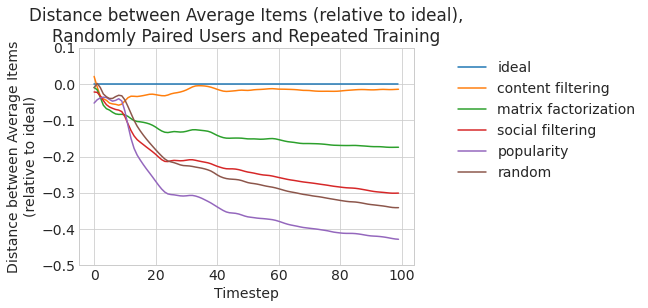

In [48]:
graph_relative_to_ideal(rep_train_results, "mean_item_dist", model_keys, id_to_readable)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

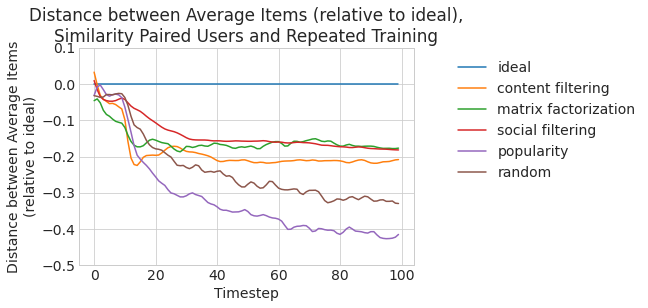

In [51]:
graph_relative_to_ideal(rep_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nSimilarity Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

## Single training

In [52]:
sim_args = {
    "startup_iters": 50,
    "sim_iters": 50,
    "repeated_training": False,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}


In [53]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    single_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(single_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = single_train_models["ideal"].actual_item_attributes
    single_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_models[model_key]
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


### Average distance between mean items

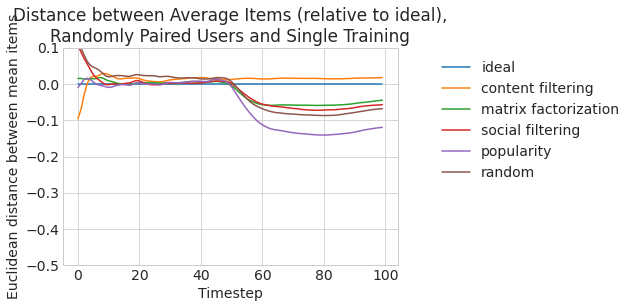

In [54]:
graph_relative_to_ideal(single_train_results, "mean_item_dist", model_keys, id_to_readable)

plt.ylabel("Euclidean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

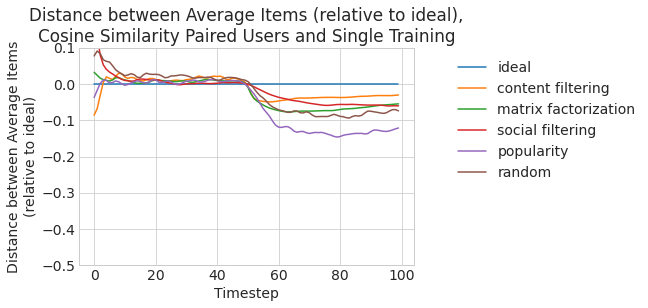

In [55]:
graph_relative_to_ideal(single_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)

plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Experimental analysis

## Scratch work: examine dynamic content creators

In [66]:
# results = merge_results([
#     "exps/creator_hom_rep_500", "exps/creator_hom_rep_500_2", "exps/creator_hom_rep_500_3", "exps/creator_hom_rep_500_4", "exps/creator_hom_rep_500_5",
#     "exps/creator_hom_rep_500_6", "exps/creator_hom_rep_500_7", "exps/creator_hom_rep_500_8"])

In [7]:
results = merge_results([
    "exps/clean/batch_1", "exps/clean/batch_2", "exps/clean/batch_3", "exps/clean/batch_4", "exps/clean/batch_5",
    "exps/clean/batch_6", "exps/clean/batch_7", "exps/clean/batch_8"])

In [8]:
# make relative to first timestep
for m in model_keys:
    x = np.array(results['creator_item_homo'][m])
    x = x - x[:, 0][:, np.newaxis]
    results['creator_item_homo'][m] = x

Text(0, 0.5, 'Average Pairwise Item Distance')

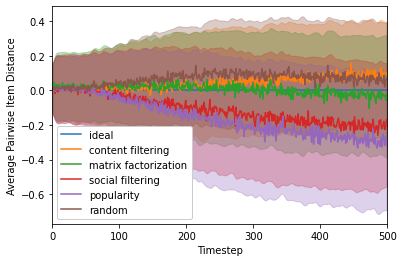

In [9]:
# graph_metrics(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0)
graph_relative_to_ideal(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0, absolute_measure=True)
plt.xlim(0, 500)
plt.legend(facecolor='white', framealpha=1, loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Average Pairwise Item Distance")
# plt.savefig("figures/creator_repeated_item_homo.pdf")

In [69]:
results = merge_results([
    "exps/creator_hom_rep_500_w_prof"])

In [10]:
from scipy.stats import dirichlet

In [11]:
ideal_profs= np.array(results['creator_profiles']['ideal'])

In [12]:
num_sims, num_steps, num_creators, num_attrs = ideal_profs.shape

In [13]:
def avg_creator_entropy(creator_profs):
    """ Takes creators array (row = creator, col = attributes)
        and calculates average Dirichlet entropy across all creators
    """
    num_creators = creator_profs.shape[0]
    avg_entropy = 0
    for i in range(num_creators):
        # 0.1 multiplier is from the item-generating process
        avg_entropy += dirichlet.entropy(creator_profs[i, :] * 0.1) / num_creators
    return avg_entropy

In [14]:
def calc_avg_entropy_per_timestep(results, model_keys, num_trials, num_timesteps):
    new_results = {}
    new_results['avg_creator_entropy'] = {}
    for model_key in model_keys:
        entropies = np.zeros((num_trials, num_timesteps))
        creator_profs = np.array(results['creator_profiles'][model_key])
        for i in range(num_trials):
            for j in range(num_timesteps):
                entropies[i, j] = avg_creator_entropy(creator_profs[i, j, :])
        new_results['avg_creator_entropy'][model_key] = entropies
    return new_results

In [15]:
start_entropy = avg_creator_entropy(ideal_profs[0, 0, :])
end_entropy = avg_creator_entropy(ideal_profs[0, 499, :])
print("Average entropy at start of sim: ", start_entropy)
print("Average entropy at end of sim: ", end_entropy)

Average entropy at start of sim:  -4178.63231431025
Average entropy at end of sim:  -299684.43404451216


In [16]:
entropy_results = calc_avg_entropy_per_timestep(results, model_keys, num_sims, 500)

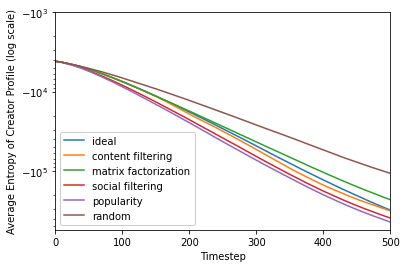

In [17]:
# graph_metrics(results, "creator_item_homo", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0)
graph_metrics(entropy_results, "avg_creator_entropy", model_keys, id_to_readable)
plt.xlim(0, 500)
plt.legend(facecolor='white', framealpha=1, loc='lower left')
plt.yscale("symlog", subsy=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks([-1000, -10000, -100000])
plt.xlabel("Timestep")
plt.ylabel("Average Entropy of Creator Profile (log scale)")
plt.savefig("figures/creator_repeated_entropy.pdf")

In [18]:
# calculate Dirichlet moment
def average_item(dirichlet_params, multiplier = 0.1):
    """
    Calculate the average item profile for a given vector of parameters
    for the Dirichlet distribution. 
    Multiplier is set to 0.1 for sparsity.
    """
    a0 = (multiplier * dirichlet_params).sum()
    return (multiplier * dirichlet_params) / a0

def item_avg_range_simulated(dirichlet_params, multiplier = 0.1, seed = 1234):
    """
    Calculate the per-property interquartile range
    Multiplier is set to 0.1 for sparsity.
    """
    # sample 1,000
    rng = np.random.default_rng(seed)
    items = rng.dirichlet(dirichlet_params * multiplier, size=10000)
    print(items.shape)
    q1 = np.percentile(items, 5, interpolation = 'midpoint', axis=0)
    q3 = np.percentile(items, 95, interpolation = 'midpoint', axis=0)
    # make relative to mean
    avg = items.mean(axis=0)
    return avg, np.vstack([avg - q1, avg - q3]) 

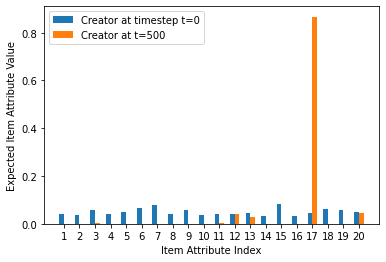

In [19]:
width = 0.3
plt.bar(np.arange(20), average_item(ideal_profs[0, 0, 0, :]), width, label="Creator at timestep t=0")
# plt.ylim(0, 0.8)
plt.bar(np.arange(20) + width, average_item(ideal_profs[0, 499, 0, :]), width, label="Creator at t=500")
plt.xticks(np.arange(20) + width/2, np.arange(20)+1)
plt.xlabel("Item Attribute Index")
plt.ylabel("Expected Item Attribute Value")
plt.legend()
plt.savefig("figures/creator_attribute_gen.pdf")